In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from astroNN.datasets import load_galaxy10
from tensorflow.keras import utils
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/

2023-05-02 20:12:18.599707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 20:12:19.589055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/spcup2022/miniconda3/envs/spcup2023/lib/
2023-05-02 20:12:19.589169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/spcup2022/miniconda3/envs/spcup2023/lib/
2023-05-02 20:12:19.589177

In [2]:
images, labels = load_galaxy10()

/home/spcup2022/.astroNN/datasets/Galaxy10_DECals.h5 was found!


In [3]:
images.shape

(17736, 256, 256, 3)

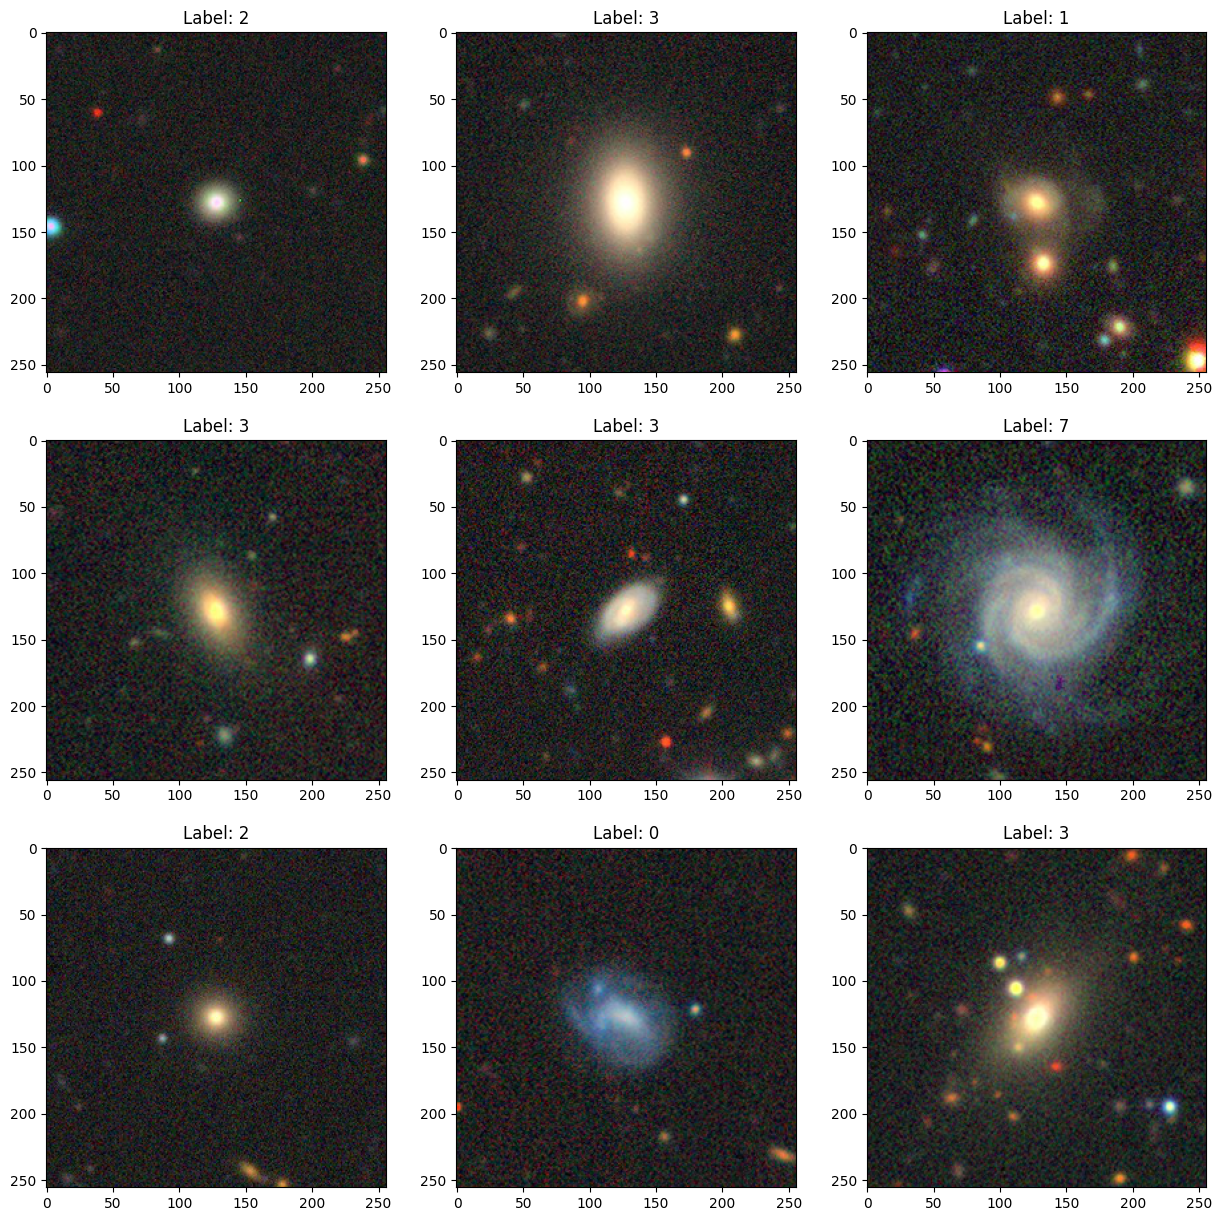

In [4]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    j = np.random.randint(0, images.shape[0])
    plt.title("Label: {}".format(labels[j]))
    plt.imshow(images[j])

In [36]:
# PCA based coding
class PCA_compression():
    def __init__(self):
        self.n_components = 200
        self.compressor = PCA(self.n_components)

    def learn(self, raw_datas):
        return self.compressor.fit(raw_datas)
    
    def scree(self, raw_data, var_per=94, scree_plot=False):
        pca = PCA()
        pca.fit(raw_data)
        
        cumulative_var = np.cumsum(pca.explained_variance_ratio_)*100
        k = np.argmax(cumulative_var>var_per)
        
        if scree_plot:
            plt.figure(figsize=[10,5])
            plt.title('Cumulative Explained Variance explained by the components')
            plt.ylabel('Cumulative Explained variance')
            plt.xlabel('Principal components')
            plt.axvline(x=k, color="k", linestyle="--")
            plt.axhline(y=var_per, color="r", linestyle="--")
            ax = plt.plot(cumulative_var)
        
        return k
        
    def compress(self, raw_data):
        return self.compressor.fit_transform(raw_data)

    def decompress(self, data):
        return self.compressor.inverse_transform(data)

    def compress_multiple(self, images):
        comp_images = []
        comp_images = [self.compress(images[i]) for i in range(len(images))]
        return np.array(comp_images)

    def decompress_multiple(self, comp_images):
        recon_images = []
        recon_images = [self.decompress(comp_images[i]) for i in range(len(comp_images))]
        return np.array(recon_images)

# ICA based coding
class ICA_compression():
    def __init__(self):
        self.n_components = 30
        self.compressor = FastICA(self.n_components)

    def learn(self, raw_datas):
        return self.compressor.fit(raw_datas)
        
    def compress(self, raw_data):
        return self.compressor.fit_transform(raw_data)

    def decompress(self, data):
        return self.compressor.inverse_transform(data)

    def compress_multiple(self, images):
        comp_images = []
        comp_images = [self.compress(images[i]) for i in range(len(images))]
        return np.array(comp_images)

    def decompress_multiple(self, comp_images):
        recon_images = []
        recon_images = [self.decompress(comp_images[i]) for i in range(len(comp_images))]
        return np.array(recon_images)


# K-means clustering
class kmeans_compression():
    def __init__(self):
        self.clusters = 150
        self.compressor = KMeans(self.clusters)

    def learn(self, raw_datas):
        return self.compressor.fit(np.log10(raw_datas+np.ones(np.shape(raw_datas))))
        
    def compress(self, raw_data):
        return self.compressor.predict(np.log10(raw_data+np.ones(np.shape(raw_data))))

    def decompress(self, data):
        x = np.power(10, self.compressor.cluster_centers_[data])
        x = x - np.ones(np.shape(x))
        return np.clip(x.astype('uint8'), 0, 255)

    def compress_multiple(self, images):
        comp_images = []
        comp_images = [self.compress(images[i]) for i in range(len(images))]
        return np.array(comp_images)

    def decompress_multiple(self, comp_images):
        recon_images = []
        recon_images = [self.decompress(comp_images[i]) for i in range(len(comp_images))]
        return np.array(recon_images)

In [5]:
# flat_images = images.reshape((images.shape[0], images.shape[1]*images.shape[2], -1))
flat_images = images.reshape((images.shape[0], -1))
flat_images.shape

training_samples = np.zeros([500, flat_images.shape[1]])
for i in range(500):
    training_samples[i] = flat_images[np.random.randint(0, flat_images.shape[0])]

In [87]:
# kmeans_compressor = kmeans_compression()
# kmeans_compressor.learn(training_samples)
kmeans_compressor = read_object(path_write + 'kmeans_compressor.pkl')

In [88]:
# comp_img = kmeans.cluster_centers_[kmeans.predict(np.log10(flat_images+np.ones(np.shape(flat_images))))]
comp_img = kmeans_compressor.compress(flat_images)

In [92]:
np.shape(kmeans_compressor.compressor.cluster_centers_)

(50, 196608)

In [93]:
recon_img = kmeans_compressor.decompress(comp_img)

2308


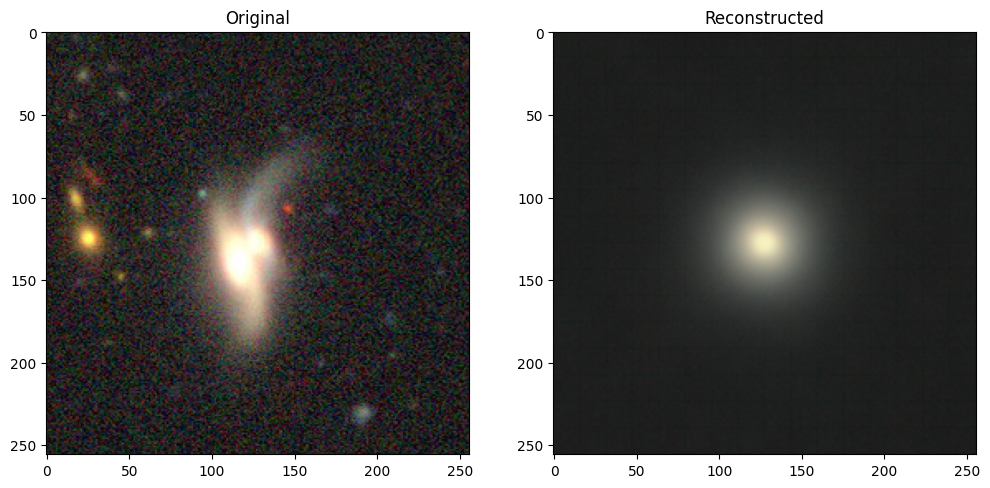

In [94]:
j = np.random.randint(0, images.shape[0])
# j = np.random.randint(101, 999)
print(j)
plt.figure(figsize=[12,12])
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(images[j])


plt.subplot(1, 2, 2)
plt.title("Reconstructed")

# dim = recon_img[j]
kmeans_compressor.decompress(comp_img[j])
dim = dim.reshape(images.shape[1], images.shape[2], 3)

plt.imshow(dim)
plt.show()

# dim==images[j]

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [ ]:
mean_squared_error(images[j], dim)

In [ ]:
ssim(images[j], dim, channel_axis=2)

In [ ]:
dim.shape

In [ ]:
help(ssim)

In [ ]:
comp_img

In [71]:
import pickle

def read_object(file):
    with open(file, 'rb') as fd:
        data = pickle.load(fd)
        fd.close()
    return data

def write_object(data, file):
    with open(file, 'wb') as fd:
        pickle.dump(data, fd)
        fd.close()

In [72]:
path_write = '/data/spcup2022/UDAY/DSmodels/'

In [73]:
write_object(kmeans_compressor, path_write + 'kmeans_compressor_150.pkl')

In [54]:
comp =  PCA_compression()
i = 9871
img = images[i].reshape((256*3, 256))
comp.learn(img)

PCA(n_components=200)

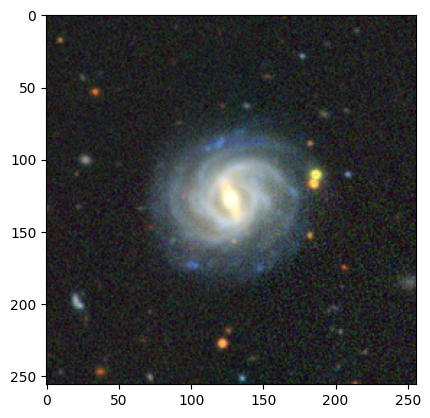

In [58]:
recon_img = comp.decompress(comp.compress(img))
recon_img = np.clip(recon_img.astype('uint8'), 0, 255)
recon_img = recon_img.reshape((256, 256, 3))
plt.imshow(images[i])

In [56]:
images[i].shape

(256, 256, 3)

In [57]:
from skimage.metrics import structural_similarity
structural_similarity(images[i], recon_img, channel_axis=2)

0.967119387897931